<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Minimum_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overall Goal: Calculate the minimum threshold amplitude that counts as frog call

###Importing libraries and packages

In [2]:
!pip install librosa
import librosa
import os
from librosa import display
import scipy
import numpy as np
import statistics
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io.wavfile import write
import math
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


###Step 1: Calculate the average of all peak amplitudes

In [3]:
file_path = '/content/Laevis_01-F818D-F8387-220616_0456_8min_selection.wav'
file_name = os.path.basename(file_path)
sampling_rate = 44100
samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

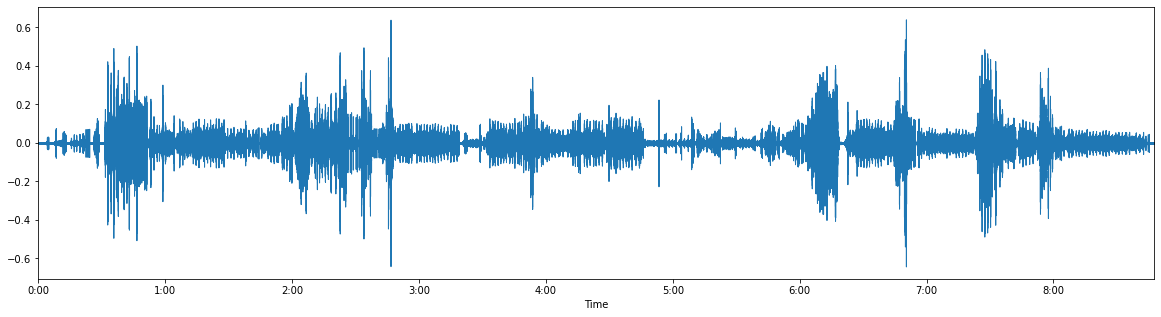

In [4]:
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=samples,sr=sampling_rate)
plt.show()

In [5]:
hilbert_signal = abs(scipy.signal.hilbert(samples))
#time vector
duration = len(samples)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate) 

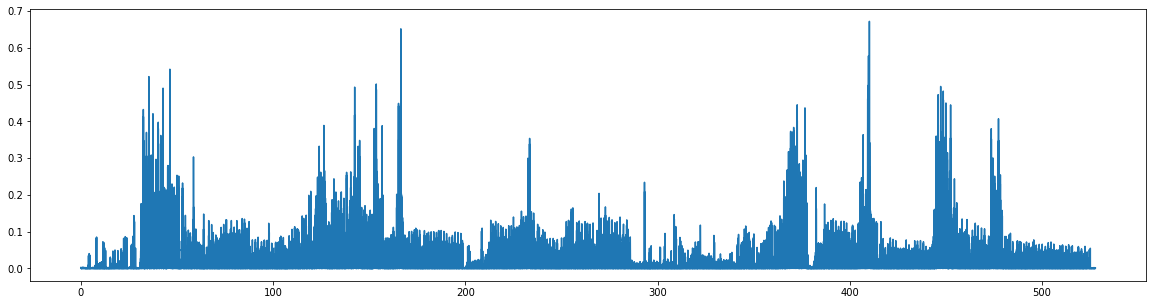

In [6]:
plt.figure(figsize=(20,5))
plt.plot(x_time,hilbert_signal)
#plt.xlim(40,41)
plt.show()

In [7]:
def z_score(data,average,std):
  error = math.exp(-10000)
  z = (data-average)/(std+error)
  return z
  
#get statistics for the amplitudes
mean_amplitude = np.mean(hilbert_signal)
median_amplitude = np.median(hilbert_signal)
stdev = np.std(hilbert_signal)
print('Mean: ',mean_amplitude)
print('STD: ',stdev)

Mean:  0.008386164720892712
STD:  0.01728211242292352


In [8]:
normalized_signal = z_score(hilbert_signal,mean_amplitude,stdev)

In [9]:
normalized_signal.min()

-0.48525079862302195

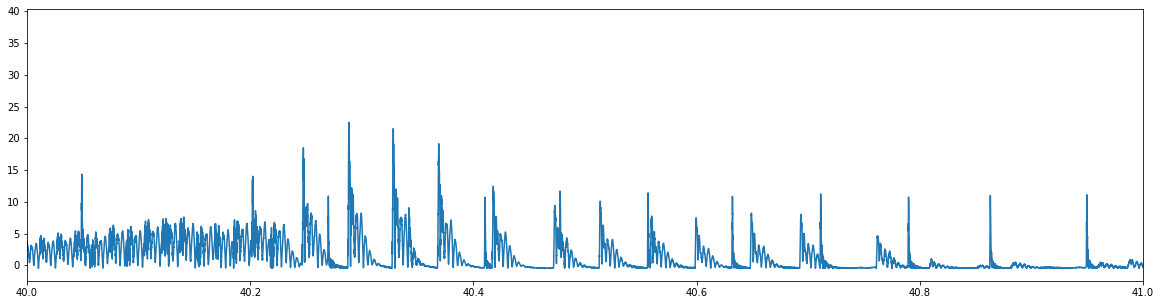

In [10]:
plt.figure(figsize=(20,5))
plt.plot(x_time,normalized_signal)
plt.xlim(40,41)
plt.show()

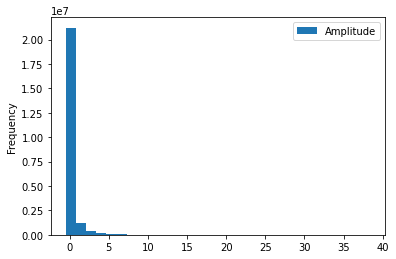

In [12]:
#threshold to count as yes signal: z_score>3
df = pd.DataFrame (normalized_signal, columns = ['Amplitude'])
df.plot.hist(bins=30)

In [15]:
print(len(normalized_signal))
std_normalized = np.std(normalized_signal)
std_normalized

23274587


1.0000000000000016

###Step 2: Use the Logistic Regression function to generate a list of probability

In [22]:
def logistic_function(x,threshold,std):
  probability = 1/(1+math.exp(-(x-threshold)))
  return probability

vectorized_logistics = np.vectorize(logistic_function)

In [24]:
#using threshold = 3 as the hard cutoff
probability_each_point = vectorized_logistics(normalized_signal,3,std_normalized)

In [26]:
max(probability_each_point)

0.9999999999999996

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

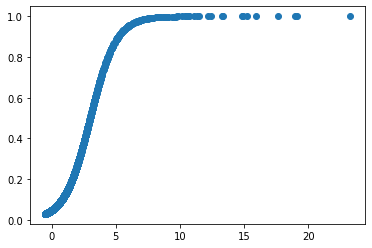

In [29]:
plt.scatter(normalized_signal[::1000],probability_each_point[::1000])
plt.show()

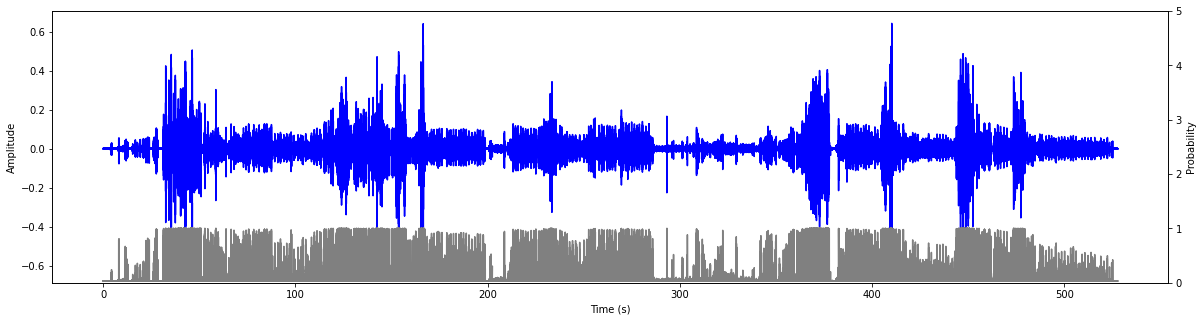

In [33]:
#plot true signal and probability likelihood
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(x_time,probability_each_point,color='grey')
ax2.set_ylabel("Probability")
ax2.set_ylim(0,5)

plt.show()